3D U-NET for lungSeg -> Infectious Area Seg


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
X_train = np.load('/content/drive/MyDrive/FYP/LungSeg_InfectAreaSegmentation/X_train_3D_LungSeg_InfSeg.npy')
y_train = np.load('/content/drive/MyDrive/FYP/LungSeg_InfectAreaSegmentation/y_train_3D_LungSeg_InfSeg.npy')
X_test = np.load('/content/drive/MyDrive/FYP/LungSeg_InfectAreaSegmentation/X_test_3D_LungSeg_InfSeg.npy')
y_test = np.load('/content/drive/MyDrive/FYP/LungSeg_InfectAreaSegmentation/y_test_3D_LungSeg_InfSeg.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((71, 128, 128, 64), (71, 128, 128, 64), (8, 128, 128, 64), (8, 128, 128, 64))

In [3]:
X_train = np.expand_dims(X_train, -1)
y_train = np.expand_dims(y_train, -1)
X_test = np.expand_dims(X_test, -1)
y_test = np.expand_dims(y_test, -1)

In [4]:
y_train = np.concatenate((1 - y_train, y_train), -1)
y_test = np.concatenate((1 - y_test, y_test), -1)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((71, 128, 128, 64, 1),
 (71, 128, 128, 64, 2),
 (8, 128, 128, 64, 1),
 (8, 128, 128, 64, 2))

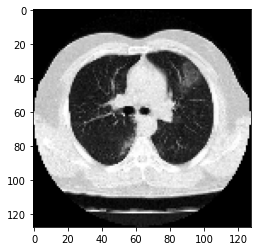

In [5]:
plt.imshow(X_train[21][:,:,38,0],cmap='gray')

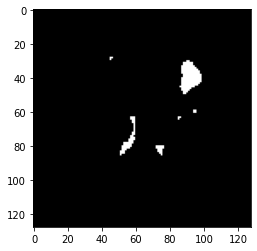

In [6]:
plt.imshow(y_train[21][:,:,38,1],cmap='gray')

In [ ]:
np.unique(y_train)

array([0, 1], dtype=int32)

In [7]:
from keras.models import *
from keras.layers.merge import concatenate
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam

In [8]:
def build_model(inp_shape, k_size=3):
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    data = Input(shape=inp_shape)
    conv1 = Convolution3D(padding='same', filters=32, kernel_size=k_size)(data)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Convolution3D(padding='same', filters=32, kernel_size=k_size)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv4 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv6 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv6)

    conv7 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(pool3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv8 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv8)

    conv9 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(pool4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    up1 = UpSampling3D(size=(2, 2, 2))(conv9)
    conv10 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(up1)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    conv11 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    merged1 = concatenate([conv11, conv8], axis=merge_axis)
    conv12 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(merged1)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)

    up2 = UpSampling3D(size=(2, 2, 2))(conv12)
    conv13 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up2)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    conv14 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)
    merged2 = concatenate([conv14, conv6], axis=merge_axis)
    conv15 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged2)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation('relu')(conv15)

    up3 = UpSampling3D(size=(2, 2, 2))(conv15)
    conv16 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up3)
    conv16 = BatchNormalization()(conv16)
    conv16 = Activation('relu')(conv16)
    conv17 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv16)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation('relu')(conv17)
    merged3 = concatenate([conv17, conv4], axis=merge_axis)
    conv18 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged3)
    conv18 = BatchNormalization()(conv18)
    conv18 = Activation('relu')(conv18)

    up4 = UpSampling3D(size=(2, 2, 2))(conv18)
    conv19 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up4)
    conv19 = BatchNormalization()(conv19)
    conv19 = Activation('relu')(conv19)
    conv20 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv19)
    conv20 = BatchNormalization()(conv20)
    conv20 = Activation('relu')(conv20)
    merged4 = concatenate([conv20, conv2], axis=merge_axis)
    conv21 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged4)
    conv21 = BatchNormalization()(conv21)
    conv21 = Activation('relu')(conv21)

    conv22 = Convolution3D(padding='same', filters=2, kernel_size=k_size)(conv21)
    output = Reshape([-1, 2])(conv22)
    output = Activation('softmax')(output)
    output = Reshape(inp_shape[:-1] + (2,))(output)

    model = Model(data, output)
    return model

In [9]:
inp_shape = (128,128,64,1)
model = build_model(inp_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer_ = ModelCheckpoint("3D_CT_Infectious_Area_Segmentation.h5", monitor='val_loss',save_best_only=True)
#model.summary()

In [ ]:
X_test.shape

(8, 128, 128, 64, 1)

In [10]:
with tf.device('/device:GPU:0'):

  hist = model.fit(
            X_train,
            y_train,
            batch_size=1,
            epochs=30,
            shuffle=False,
            verbose=2,
            #validation_data=(X_te,y_te),
            validation_split = 0.2,
            callbacks = [checkpointer_],

  )

Epoch 1/30
56/56 - 63s - loss: 0.0655 - accuracy: 0.9755 - val_loss: 0.0760 - val_accuracy: 0.9953
Epoch 2/30
56/56 - 36s - loss: 0.0174 - accuracy: 0.9953 - val_loss: 0.1088 - val_accuracy: 0.9953
Epoch 3/30
56/56 - 36s - loss: 0.0175 - accuracy: 0.9953 - val_loss: 0.1396 - val_accuracy: 0.9952
Epoch 4/30
56/56 - 36s - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.4599 - val_accuracy: 0.9585
Epoch 5/30
56/56 - 36s - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.3669 - val_accuracy: 0.9313
Epoch 6/30
56/56 - 36s - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.2057 - val_accuracy: 0.9685
Epoch 7/30
56/56 - 36s - loss: 0.0133 - accuracy: 0.9957 - val_loss: 0.1113 - val_accuracy: 0.9846
Epoch 8/30
56/56 - 36s - loss: 0.0128 - accuracy: 0.9957 - val_loss: 0.0629 - val_accuracy: 0.9912
Epoch 9/30
56/56 - 36s - loss: 0.0126 - accuracy: 0.9958 - val_loss: 0.0499 - val_accuracy: 0.9918
Epoch 10/30
56/56 - 36s - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.0384 - val_accuracy: 0.9940
Epoch 11/

In [ ]:
model.evaluate(X_test, y_test,batch_size=1)

8/8 [==============================] - 2s 226ms/step - loss: 0.1094 - accuracy: 0.9919


[0.10942238569259644, 0.9918904304504395]

In [ ]:
y_test.shape,y_pred1.shape

((8, 128, 128, 64, 2), (8, 128, 128, 64, 2))

In [ ]:
predOneDim = y_pred1[:,:,:,1]
predOneDim = np.expand_dims(predOneDim,-1)

predOneCo = np.where(predOneDim < 0.1,predOneDim,1)
predOneCo = np.where(predOneCo > 0.1,predOneCo,0)
print(predOneCo.shape)
print(np.unique(predOneCo))

(8, 128, 128, 2, 1)
[0. 1.]


In [ ]:
np.unique(np.array(predOneCo,dtype=int))

array([0, 1])

In [ ]:
np.unique(np.array(y_test,dtype=int))

array([0, 1])

In [17]:
def IoU(y_true, y_pred):
   # assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    #assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

In [20]:
ious = []
dices = []
a = 0
for i in range(8):
  ious.append(IoU(y_test[a],y_pred[a]))
  dices.append(Dice(y_test[a],y_pred[a]))
  a = a+1

ious = np.array(ious)
dices = np.array(dices)

print(np.mean(ious))
print(np.mean(dices))

0.9783907576159625
0.9889439397125532


In [11]:
model.load_weights('/content/3D_CT_Infectious_Area_Segmentation.h5')

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score

y_pred1 = model.predict(X_test,batch_size=1)
y_predNew = []

for x in y_pred1:

  predOneDim = x[:,:,:,1]
  predOneDim = np.expand_dims(predOneDim,-1)

  predOneCo = np.where(predOneDim < 0.1,predOneDim,1)
  predOneCo = np.where(predOneCo > 0.1,predOneCo,0)

  y_predNew.append(predOneCo)


#y_pred = np.argmax(y_pred1, axis=1)
#y_pred_ = to_categorical(y_pred)
# print(jaccard_score(np.array(y_test,dtype=int),np.array(y_predNew,dtype=int)))
# print(classification_report(np.array(y_test,dtype=int),np.array(y_predNew,dtype=int)))
# print(accuracy_score(y_test,np.array(y_predNew)))

In [14]:
y_pred = np.concatenate((1 - np.array(y_predNew), np.array(y_predNew)), -1)

In [15]:
y_pred.shape

(8, 128, 128, 64, 2)

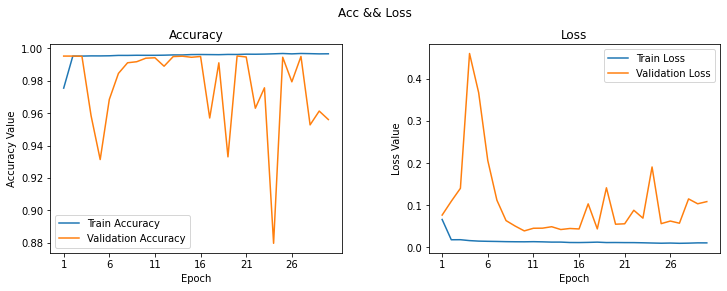

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Acc && Loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(hist.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

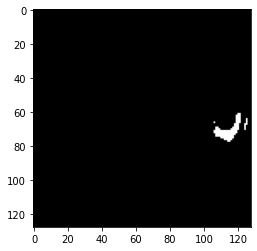

In [19]:
plt.imshow(y_pred[0][:,:,40,1],cmap='gray')